# Imports

In [4]:
## LOAD LIBRARIES
import pandas as pd
import numpy as np

# Import all we need from sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

#Import optuna
import optuna

# Import visualization
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\casey\anaconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [5]:
df = pd.read_csv('C:/Users/casey/OneDrive/Documents/Data_Science/Machine_Learning/Supervised_Learning/Data/Clean_Data_Titanic.csv')
print(df.head())

   survived  pclass     sex   age  sibsp  parch     fare embarked  adult_male  \
0         0       3    male  22.0      1      0   7.2500        S        True   
1         1       1  female  38.0      1      0  71.2833        C       False   
2         1       3  female  26.0      0      0   7.9250        S       False   
3         1       1  female  35.0      1      0  53.1000        S       False   
4         0       3    male  35.0      0      0   8.0500        S        True   

   alone  
0  False  
1  False  
2   True  
3  False  
4   True  


# Label Encoding

In [6]:
## CONVERT CATEGORICAL LABELS TO NUMERIC LABELS

le = LabelEncoder()
df['survived'] = le.fit_transform(df['survived'])

# OneHot Encoding of Categorical Variables

In [7]:
label_col = 'survived'

labels = df[label_col]
df.drop([label_col], inplace=True, axis=1)
df = pd.get_dummies(df, dtype='int', columns = ['pclass', 'sex', 'embarked', 'alone', 'adult_male'])
df[label_col] = labels

# Create Train and Test Sets

### For No Cross Validation

In [8]:
# X will contain all variables except the labels (the labels are the first column 'survived')
X = df.iloc[:,:-1]
# y will contain the labels (the labels are the first column 'survived')
y = df['survived']
               
# split the data vectors randomly into 80% train and 20% test
# X_train contains the quantitative variables for the training set
# X_test contains the quantitative variables for the testing set
# y_train contains the labels for training set
# y_test contains the lables for the testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Fit Initial Model

In [9]:
# documentation for parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

RF_Classifier = RandomForestClassifier()
RF_Classifier.fit(X_train, y_train)

## EVALUATE MODEL
y_pred = RF_Classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[97 13]
 [15 54]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       110
           1       0.81      0.78      0.79        69

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



# Tune Model - W/O Cross Validation

In [16]:
def objective(trial, X_train, y_train, X_test, y_test):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 200, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 10),
        "max_features": 'sqrt',
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        # 'weight_0': trial.suggest_float('weight_0', 0.1, 4),
        # 'weight_1': trial.suggest_float('weight_1', 0.1, 4),
    }

    # Fit the model
    optuna_model = RandomForestClassifier(**param)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    score_metric = f1_score(y_true=y_test, y_pred=y_pred, average='macro')
    return score_metric

In [17]:
# Generate a new study resetting trials to 0
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
    direction="maximize"
)

[I 2024-03-23 16:23:20,450] A new study created in memory with name: no-name-33507500-371c-4688-b181-0b5317f4096f


In [18]:
# study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test, score_function), n_trials=100)
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=100)

print('Best Trial: ', study.best_trial)
print('Best Params: ',study.best_params)
best_params = study.best_params

[I 2024-03-23 16:23:23,204] Trial 0 finished with value: 0.828549724213099 and parameters: {'n_estimators': 182, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 0 with value: 0.828549724213099.
[I 2024-03-23 16:23:23,512] Trial 1 finished with value: 0.828549724213099 and parameters: {'n_estimators': 158, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 0 with value: 0.828549724213099.
[I 2024-03-23 16:23:23,576] Trial 2 finished with value: 0.8015779864371413 and parameters: {'n_estimators': 32, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 0 with value: 0.828549724213099.
[I 2024-03-23 16:23:23,660] Trial 3 finished with value: 0.8123197903014416 and parameters: {'n_estimators': 23, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 0 with value: 0.828549724213099.
[I 2024-03-23 16:23:23

Best Trial:  FrozenTrial(number=18, state=1, values=[0.8615529475064734], datetime_start=datetime.datetime(2024, 3, 23, 16, 23, 26, 340011), datetime_complete=datetime.datetime(2024, 3, 23, 16, 23, 26, 472248), params={'n_estimators': 14, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 5, 'bootstrap': True}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=200, log=True, low=10, step=1), 'max_depth': IntDistribution(high=15, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=2, step=1), 'bootstrap': CategoricalDistribution(choices=(True, False))}, trial_id=18, value=None)
Best Params:  {'n_estimators': 14, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 5, 'bootstrap': True}


### Cross Validate Tuned Model

In [19]:
cv_model = RandomForestClassifier(**best_params)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scores = cross_val_score(cv_model, X_train, y_train, cv = skf, scoring=make_scorer(f1_score, average='macro'))

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.79144385 0.76275087 0.76147816 0.78582202 0.84134078]
Average CV Score:  0.7885671373363655
Number of CV Scores used in Average:  5


# Tune Model With Cross Validation

In [20]:
def objective(trial, X_train, y_train):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 200, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 10),
        "max_features": 'sqrt',
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        # 'weight_0': trial.suggest_float('weight_0', 0.1, 4),
        # 'weight_1': trial.suggest_float('weight_1', 0.1, 4),
    }

    # Fit the model with cv
    cv_model = RandomForestClassifier(**param)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    scores = cross_val_score(cv_model, X_train, y_train, cv = skf, scoring=make_scorer(f1_score, average='macro'))

    # Evaluate predictions
    return scores.mean()

In [21]:
# Generate a new study resetting trials to 0
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
    direction="maximize"
)

[I 2024-03-23 16:25:37,125] A new study created in memory with name: no-name-73626c31-b1e8-496d-9639-1d16b0de1502


In [22]:
# study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test, score_function), n_trials=100)
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

print('Best Trial: ', study.best_trial)
print('Best Params: ',study.best_params)
best_params = study.best_params

[I 2024-03-23 16:25:40,993] Trial 0 finished with value: 0.7989155147840974 and parameters: {'n_estimators': 27, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 0 with value: 0.7989155147840974.
[I 2024-03-23 16:25:41,415] Trial 1 finished with value: 0.805609060241092 and parameters: {'n_estimators': 51, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 1 with value: 0.805609060241092.
[I 2024-03-23 16:25:41,550] Trial 2 finished with value: 0.7973509003386915 and parameters: {'n_estimators': 12, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 1 with value: 0.805609060241092.
[I 2024-03-23 16:25:41,724] Trial 3 finished with value: 0.8135192053453416 and parameters: {'n_estimators': 15, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 3 with value: 0.8135192053453416.
[I 2024-03-23 16:2

Best Trial:  FrozenTrial(number=24, state=1, values=[0.8171621814385954], datetime_start=datetime.datetime(2024, 3, 23, 16, 25, 59, 863237), datetime_complete=datetime.datetime(2024, 3, 23, 16, 26, 0, 951103), params={'n_estimators': 122, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': False}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=200, log=True, low=10, step=1), 'max_depth': IntDistribution(high=15, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=2, step=1), 'bootstrap': CategoricalDistribution(choices=(True, False))}, trial_id=24, value=None)
Best Params:  {'n_estimators': 122, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': False}


### Validate CV Model with Test Set

In [23]:
xgb_Classifier = RandomForestClassifier(**best_params)
xgb_Classifier.fit(X_train, y_train)

## EVALUATE MODEL
y_pred = xgb_Classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[97 13]
 [14 55]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       110
           1       0.81      0.80      0.80        69

    accuracy                           0.85       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



# Confusion Matrix

[[97 13]
 [14 55]]


[Text(0, 0.5, '0:'), Text(0, 1.5, '1:')]

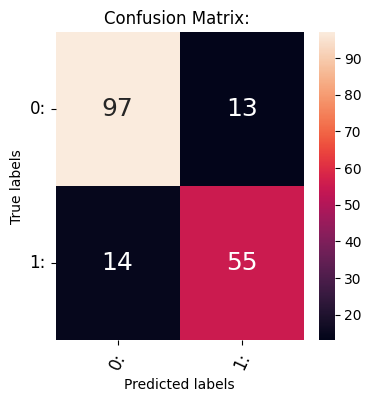

In [24]:
cm=confusion_matrix(y_pred=y_pred, y_true=y_test)
print(cm)

# ---------------------------------------------------------------------------------------------------------------------------- #
## PLOT A PRETTY CONFUSION MATRIX
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={'size': 18})
#annot=True to annotate cells, ftm='g' to disable scientific notation
# annot_kws si size  of font in heatmap
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix: ')
ax.xaxis.set_ticklabels(["0:","1:"],rotation=65, fontsize = 12)

ax.yaxis.set_ticklabels(["0:","1:"],rotation=0, fontsize = 12)